In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
from igraph import Graph
import cairocffi
from collections import defaultdict

In [3]:
associations = pd.read_csv('data/bio-pathways-associations.csv')
classes = pd.read_csv('data/bio-pathways-diseaseclasses.csv')
dmotifs = pd.read_csv('data/bio-pathways-diseasemotifs.csv')
features = pd.read_csv('data/bio-pathways-features.csv')
network = pd.read_csv('data/bio-pathways-network.csv')
pmotifs = pd.read_csv('data/bio-pathways-proteinmotifs.csv')
node_classes = pd.read_csv('data/all-proteins.csv', index_col=0)
diseased_classes = pd.read_csv('data/diseased-proteins.csv', index_col=0)

## Associations

In [3]:
associations.head()

Disease ID                  Disease Name  \
0   C0036095      Salivary Gland Neoplasms   
1   C0033941  Psychoses, Substance-Induced   
2   C0043459            Zellweger Syndrome   
3   C0033860                     Psoriasis   
4   C0027726            Nephrotic Syndrome   

                                 Associated Gene IDs  
0  1462, 1612, 182, 2011, 2019, 2175, 2195, 23209...  
1  135, 1636, 207, 2099, 2912, 2950, 3350, 3362, ...  
2  3295, 5189, 5190, 5192, 5193, 5194, 5195, 5567...  
3  100271719, 10318, 10498, 10547, 10758, 10866, ...  
4  1277, 1282, 1284, 2, 213, 2152, 2247, 2262, 29...

In [4]:
associations.describe()

Disease ID         Disease Name  \
count         519                  519   
unique        519                  519   
top      C0014556  Acute kidney injury   
freq            1                    1   

                                      Associated Gene IDs  
count                                                 519  
unique                                                513  
top     2253, 2619, 2736, 28514, 4838, 50937, 5727, 64...  
freq                                                    4

## Disease classes

In [5]:
classes.head()

Disease ID              Disease Name                  Disease Class
0   C0023903           Liver neoplasms                         cancer
1   C0018798  Congenital Heart Defects  cardiovascular system disease
2   C0027051     Myocardial Infarction  cardiovascular system disease
3   C0028754                   Obesity     acquired metabolic disease
4   C0005138               Berylliosis     respiratory system disease

In [6]:
classes.describe()

Disease ID  Disease Name Disease Class
count         300           300           300
unique        300           300            30
top      C0014556  Pancreatitis        cancer
freq            1             1            68

## Disease motifs

In [7]:
dmotifs.head()

Disease ID                  Disease Name  P-values for each orbit  \
0   C0036095      Salivary Gland Neoplasms                   0.2868   
1   C0033941  Psychoses, Substance-Induced                   0.6732   
2   C0043459            Zellweger Syndrome                   0.5018   
3   C0033860                     Psoriasis                   0.0034   
4   C0027726            Nephrotic Syndrome                   0.3848   

   Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0      0.1406      1.0000      0.9996      0.1822      0.9994      0.2686   
1      0.2918      0.9986      0.9854      0.4228      0.9984      0.0696   
2      0.4802      0.7728      0.7928      0.2640      0.8392      0.4160   
3      0.0000      0.9802      0.9884      0.0000      0.9894      0.0446   
4      0.0756      1.0000      0.9894      0.1678      0.9984      0.3860   

   Unnamed: 9  ...  Unnamed: 65  Unnamed: 66  Unnamed: 67  Unnamed: 68  \
0      0.9998  ...       0.9992       1.0000       0.9988       0.9978   
1      0.9970  ...       0.9872       0.9862       0.9308       0.9812   
2      0.7320  ...       0.7040       0.5930       0.8620       0.8434   
3      0.9944  ...       0.9486       0.9218       0.9586       0.9618   
4      0.9988  ...       0.9918       0.9834       0.9722       0.9866   

   Unnamed: 69  Unnamed: 70  Unnamed: 71  Unnamed: 72  Unnamed: 73  \
0       0.9996       0.9998       1.0000       0.9908       0.9980   
1       0.9788       0.9660       0.9962       0.9724       0.9730   
2       0.8360       0.6456       0.0000       0.8376       0.9066   
3       0.9618       0.8456       0.0000       0.8756       0.0000   
4       0.9956       0.9940       0.9966       0.9492       0.9898   

   Unnamed: 74  
0       0.9944  
1       0.9844  
2       0.0000  
3       0.0000  
4       0.9720  

[5 rows x 75 columns]

In [8]:
dmotifs.describe()

P-values for each orbit  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
count               519.000000  519.000000  519.000000  519.000000   
mean                  0.390649    0.258887    0.902943    0.895556   
std                   0.302447    0.271436    0.181507    0.187775   
min                   0.000000    0.000000    0.000000    0.000000   
25%                   0.130000    0.034200    0.885200    0.888200   
50%                   0.335000    0.165600    0.982000    0.979600   
75%                   0.620000    0.389600    0.999500    0.998800   
max                   0.998200    0.983600    1.000000    1.000000   

       Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
count  519.000000  519.000000  519.000000   519.00000   519.000000   
mean     0.285543    0.896049    0.294663     0.90265     0.849971   
std      0.271206    0.191393    0.249950     0.18890     0.216353   
min      0.000000    0.000000    0.000000     0.00000     0.000000   
25%      0.056900    0.878700    0.076300     0.90050     0.775800   
50%      0.190800    0.987800    0.230000     0.98920     0.954800   
75%      0.453400    0.999600    0.464600     0.99980     0.997800   
max      0.982800    1.000000    0.978600     1.00000     1.000000   

       Unnamed: 11  ...  Unnamed: 65  Unnamed: 66  Unnamed: 67  Unnamed: 68  \
count   519.000000  ...   519.000000   519.000000   519.000000   519.000000   
mean      0.499053  ...     0.866909     0.860435     0.841662     0.831766   
std       0.292587  ...     0.215899     0.238677     0.228640     0.299034   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.262600  ...     0.818200     0.829300     0.775400     0.828700   
50%       0.518000  ...     0.968800     0.969000     0.945000     0.964400   
75%       0.746100  ...     0.999400     0.999700     0.996900     0.999600   
max       0.994600  ...     1.000000     1.000000     1.000000     1.000000   

       Unnamed: 69  Unnamed: 70  Unnamed: 71  Unnamed: 72  Unnamed: 73  \
count   519.000000   519.000000   519.000000   519.000000   519.000000   
mean      0.797350     0.853201     0.549867     0.806204     0.656933   
std       0.361448     0.257473     0.489598     0.328585     0.456462   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.861500     0.841800     0.000000     0.811800     0.000000   
50%       0.979000     0.966400     0.949200     0.962600     0.959000   
75%       0.999800     0.999600     0.999400     0.999000     0.999400   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       Unnamed: 74  
count   519.000000  
mean      0.548546  
std       0.486747  
min       0.000000  
25%       0.000000  
50%       0.923200  
75%       0.998400  
max       1.000000  

[8 rows x 73 columns]

## Features

In [9]:
features.head()

Disease ID                  Disease Name  Size of largest pathway component  \
0   C0036095      Salivary Gland Neoplasms                           0.088889   
1   C0033941  Psychoses, Substance-Induced                           0.352941   
2   C0043459            Zellweger Syndrome                           1.000000   
3   C0033860                     Psoriasis                           0.250000   
4   C0027726            Nephrotic Syndrome                           0.095238   

   Density of pathway  Network Modularity  Distance of Pathway Components  \
0            0.019192           -0.006214                        2.925300   
1            0.117647           -0.008137                        2.840909   
2            0.352381           -0.001201                             NaN   
3            0.018354           -0.013313                        3.008827   
4            0.085714           -0.004027                        2.781046   

   Spatial Network Association  
0                     0.404333  
1                     0.256645  
2                     0.132935  
3                     0.225171  
4                     0.214739

In [10]:
features.describe()

Size of largest pathway component  Density of pathway  \
count                         519.000000          519.000000   
mean                            0.284809            0.085650   
std                             0.209658            0.079820   
min                             0.023256            0.000000   
25%                             0.125000            0.032195   
50%                             0.207547            0.066667   
75%                             0.400893            0.111111   
max                             1.000000            0.683333   

       Network Modularity  Distance of Pathway Components  \
count          519.000000                      514.000000   
mean            -0.007971                        2.911952   
std              0.011424                        0.255577   
min             -0.105434                        2.000000   
25%             -0.009337                        2.761905   
50%             -0.004027                        2.933333   
75%             -0.001726                        3.080912   
max             -0.000195                        3.529762   

       Spatial Network Association  
count                 5.190000e+02  
mean                  4.421181e-01  
std                   3.238618e-01  
min                   4.710000e-09  
25%                   1.586132e-01  
50%                   3.680776e-01  
75%                   7.415754e-01  
max                   1.000000e+00

## Diseases

In [4]:
diseases = pd.merge(associations, classes)

In [135]:
diseases.to_csv('data/disease_class_prot.csv')

In [24]:
node_dict = defaultdict(set)
for row in diseases.iterrows():
    nodes = row[1]['Associated Gene IDs'].split(', ')
    disease = row[1]['Disease Class']
    for node in nodes:
        node_dict[node].add(disease)

In [25]:
class_col = diseases['Disease Class'].unique()
class_node_dict = defaultdict(list)
for node, ds in node_dict.items():
    class_node_dict[node] = [1 if d in ds else 0 for d in class_col]
diseased_node_classes = pd.DataFrame(data=class_node_dict).transpose()
diseased_node_classes.columns = class_col

In [26]:
diseased_node_classes

inherited metabolic disorder  integumentary system disease  \
3295                              1                             0   
5189                              1                             0   
5190                              1                             0   
5192                              1                             0   
5193                              1                             0   
...                             ...                           ...   
54575                             0                             0   
54576                             0                             0   
55824                             0                             0   
6563                              0                             0   
6620                              0                             0   

       urinary system disease  nervous system disease  \
3295                        0                       1   
5189                        0                       1   
5190                        0                       0   
5192                        0                       0   
5193                        0                       0   
...                       ...                     ...   
54575                       0                       0   
54576                       0                       0   
55824                       0                       0   
6563                        0                       0   
6620                        0                       1   

       gastrointestinal system disease  substance-related disorder  \
3295                                 0                           0   
5189                                 0                           0   
5190                                 0                           0   
5192                                 0                           0   
5193                                 0                           0   
...                                ...                         ...   
54575                                0                           0   
54576                                0                           0   
55824                                0                           0   
6563                                 0                           0   
6620                                 0                           0   

       immune system disease  musculoskeletal system disease  \
3295                       0                               0   
5189                       0                               0   
5190                       0                               0   
5192                       0                               0   
5193                       0                               0   
...                      ...                             ...   
54575                      0                               0   
54576                      0                               0   
55824                      0                               0   
6563                       0                               0   
6620                       0                               0   

       psoriatic arthritis  cancer  ...  chromosomal disease  hypospadias  \
3295                     0       0  ...                    0            0   
5189                     0       0  ...                    0            0   
5190                     0       0  ...                    0            0   
5192                     0       0  ...                    0            0   
5193                     0       0  ...                    0            0   
...                    ...     ...  ...                  ...          ...   
54575                    0       1  ...                    0            0   
54576                    0       1  ...                    0            0   
55824                    0       1  ...                    0            0   
6563                     0       1  ...                    0            0   
6620                     0       0  

## PPI Network

In [11]:
network.head()

Gene ID 1  Gene ID 2
0       1394       2778
1       6331      17999
2     122704      54460
3       2597       2911
4       4790      79155

In [28]:
graph = nx.from_pandas_edgelist(network, 'Gene ID 1', 'Gene ID 2')

In [13]:
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 21557\nNumber of edges: 342353\nAverage degree:  31.7626'

In [43]:
diseased_network = network[network['Gene ID 1'].isin(diseased_nodes) & network['Gene ID 2'].isin(diseased_nodes)]

In [44]:
diseased_network

Gene ID 1  Gene ID 2
0            1394       2778
3            2597       2911
6             109      27115
16           2355      29922
27           5879      23568
...           ...        ...
342330      57521     253260
342332        267        488
342334      79026      10963
342344       1786      65125
342349       6774      55748

[65674 rows x 2 columns]

In [50]:
# dis_graph = nx.from_pandas_edgelist(diseased_network, 'Gene ID 1', 'Gene ID 2')
# nx.write_gml(dis_graph, 'diseased-ppi')
dis_graph = nx.read_gml('networks/diseased-ppi')

In [130]:
adding = defaultdict(list)
for node in graph.nodes():
    gene = str(node)
    if gene not in diseased_node_classes.index:
        adding[gene] = [0] * len(class_col)
nondiseased = pd.DataFrame(adding).transpose()
nondiseased.columns=class_col
node_classes = pd.concat([diseased_node_classes, nondiseased])

In [131]:
# All nodes including no disease association
node_classes

inherited metabolic disorder  integumentary system disease  \
3295                                  1                             0   
5189                                  1                             0   
5190                                  1                             0   
5192                                  1                             0   
5193                                  1                             0   
...                                 ...                           ...   
19400                                 0                             0   
81918                                 0                             0   
139378                                0                             0   
18744                                 0                             0   
100360522                             0                             0   

           urinary system disease  nervous system disease  \
3295                            0                       1   
5189                            0                       1   
5190                            0                       0   
5192                            0                       0   
5193                            0                       0   
...                           ...                     ...   
19400                           0                       0   
81918                           0                       0   
139378                          0                       0   
18744                           0                       0   
100360522                       0                       0   

           gastrointestinal system disease  substance-related disorder  \
3295                                     0                           0   
5189                                     0                           0   
5190                                     0                           0   
5192                                     0                           0   
5193                                     0                           0   
...                                    ...                         ...   
19400                                    0                           0   
81918                                    0                           0   
139378                                   0                           0   
18744                                    0                           0   
100360522                                0                           0   

           immune system disease  musculoskeletal system disease  \
3295                           0                               0   
5189                           0                               0   
5190                           0                               0   
5192                           0                               0   
5193                           0                               0   
...                          ...                             ...   
19400                          0                               0   
81918                          0                               0   
139378                         0                               0   
18744                          0                               0   
100360522                      0                               0   

           psoriatic arthritis  cancer  ...  chromosomal disease  hypospadias  \
3295                         0       0  ...                    0            0   
5189                         0       0  ...                    0            0   
5190                         0       0  ...                    0            0   
5192                         0       0  ...                    0            0   
5193                         0       0  ...                    0            0   
...                        ...     ...  ...                  ...          ...   
19400                        0       0  ...                    0            0   
81918                        0       0  ...    

In [124]:
diseased_node_classes.to_csv('data/diseased-proteins.csv')

In [133]:
node_classes.to_csv('data/all-proteins.csv')

In [18]:
disSet = set(diseased_classes.index)
dis = [1 if node in disSet else 0 for node in node_classes.index]

bin_nodes = node_classes.assign(diseased=dis)
bin_nodes = bin_nodes[['diseased']]

In [21]:
bin_nodes.to_csv('data/binary-classes.csv')

**FANMOD Network Motif Analysis**

In [14]:
# ppi = Graph.from_networkx(graph)
# nx.write_gml(graph, 'ig-ppi')
ppi = Graph.Read_GML('networks/ig-ppi')

In [7]:
Graph.motifs_randesu(ppi, size=3)

[nan, nan, 53217400, 2394644]

In [15]:
counts3 = Graph.motifs_randesu(ppi, size=3, cut_prob=[0.9,0.8,0.7])

In [16]:
for i,c in enumerate(counts3):
    if not np.isnan(c):
        print(i, c)

2 312118
3 17890


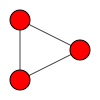

In [17]:
g = Graph.Isoclass(3,3)
ig.plot(g, bbox = (100, 100))

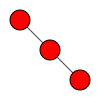

In [18]:
ig.plot(Graph.Isoclass(3,2), bbox=(100,100))

In [19]:
Graph.motifs_randesu(ppi, size=4)

KeyboardInterrupt: 

counts = [nan, nan, nan, nan, 1208083, nan, 999766, 108835, 2808, 3837, 2144]

In [21]:
counts4 = Graph.motifs_randesu(ppi, size=4, cut_prob=[0.9,0.8,0.7,0.5])
counts4

[nan, nan, nan, nan, 1186866, nan, 934969, 99309, 2597, 3795, 1827]

In [22]:
for i,c in enumerate(counts4):
    if not np.isnan(c):
        print(i,c)

4 1186866
6 934969
7 99309
8 2597
9 3795
10 1827


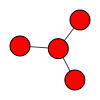

In [23]:
ig.plot(Graph.Isoclass(4,4), bbox=(100,100))

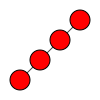

In [24]:
ig.plot(Graph.Isoclass(4,6), bbox=(100,100))

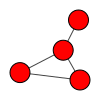

In [25]:
ig.plot(Graph.Isoclass(4,7), bbox=(100,100))

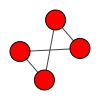

In [26]:
ig.plot(Graph.Isoclass(4,8), bbox=(100,100))

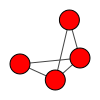

In [27]:
ig.plot(Graph.Isoclass(4,9), bbox=(100,100))

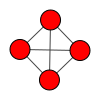

In [28]:
ig.plot(Graph.Isoclass(4,10), bbox=(100,100))

In [70]:
motifDict = defaultdict(list)
sampled_vertices = set()
def counter(graph, vertices, motif):
    motifDict[motif].append(vertices)
    for v in vertices:
        sampled_vertices.add(v)

In [74]:
Graph.motifs_randesu(ppi, size=4, cut_prob=[0.9,0.8,0.7,0.6], callback=counter)

In [75]:
for key in motifDict.keys():
    print("motif ", key, "size ", len(motifDict[key]))

motif  6 size  2461902
motif  4 size  2534151
motif  8 size  8383
motif  7 size  269873
motif  9 size  11094
motif  10 size  3793


In [76]:
len(sampled_vertices)

20570

## Protein motifs

In [29]:
pmotifs.head()

Gene ID  Orbit Signature  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0        1               12        1925          65           1      228182   
1       10               24        4723         259          17      453121   
2      100               32        5186         478          18      585573   
3     1000               78       11189        2790         213     1332626   
4    10000               76       11270        2624         226     1542635   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  Unnamed: 64  \
0       19497      280706         210         596  ...          142   
1       95381     2467189        1678        1249  ...          279   
2      141129     1444972        4449        2201  ...          656   
3      694166     3827388       62206       10013  ...        15341   
4      689984     1626042       55589       19746  ...        42472   

   Unnamed: 65  Unnamed: 66  Unnamed: 67  Unnamed: 68  Unnamed: 69  \
0            0          120            0            0            0   
1          244         1021           28            3           54   
2          454        22088          553            8          301   
3         9178       224983        17453         3911         5949   
4        17290        25317        11970         2960        10240   

   Unnamed: 70  Unnamed: 71  Unnamed: 72  Unnamed: 73  
0            0            0            0            0  
1            1            1            0            0  
2            1          169            1            0  
3          200         5929          552           96  
4          366         1706          359           43  

[5 rows x 74 columns]

In [30]:
pmotifs.describe()

Gene ID  Orbit Signature     Unnamed: 2    Unnamed: 3  \
count  2.255200e+04     22552.000000   22552.000000  2.255200e+04   
mean   2.582002e+06        30.031571    4719.528201  2.359764e+03   
std    1.547417e+07        66.969864    8662.697806  2.891876e+04   
min    1.000000e+00         0.000000       0.000000  0.000000e+00   
25%    8.534750e+03         2.000000     338.750000  0.000000e+00   
50%    5.382850e+04         9.000000    1644.000000  2.800000e+01   
75%    1.335645e+05        30.000000    5130.500000  3.820000e+02   
max    1.028003e+08      2130.000000  128448.000000  2.255358e+06   

         Unnamed: 4    Unnamed: 5    Unnamed: 6    Unnamed: 7    Unnamed: 8  \
count  22552.000000  2.255200e+04  2.255200e+04  2.255200e+04  2.255200e+04   
mean     318.549663  5.197298e+05  5.197298e+05  1.305885e+06  4.352951e+05   
std     1731.550422  9.626748e+05  3.913586e+06  2.054682e+06  1.626372e+07   
min        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000  3.737325e+04  0.000000e+00  3.038100e+04  0.000000e+00   
50%        3.000000  1.534095e+05  8.179500e+03  2.945340e+05  5.000000e+01   
75%       44.000000  5.413622e+05  1.123032e+05  1.921222e+06  2.833250e+03   
max    40639.000000  1.119295e+07  2.337301e+08  1.608145e+07  1.583236e+09   

         Unnamed: 9  ...   Unnamed: 64   Unnamed: 65   Unnamed: 66  \
count  2.255200e+04  ...  2.255200e+04  2.255200e+04  2.255200e+04   
mean   9.157916e+03  ...  6.815916e+04  6.815916e+04  1.575168e+05   
std    5.126846e+04  ...  7.065086e+05  5.278503e+05  8.627215e+05   
min    0.000000e+00  ...  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  ...  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.330000e+02  ...  9.000000e+00  1.000000e+00  1.210000e+02   
75%    2.105000e+03  ...  1.077000e+03  9.952500e+02  1.054600e+04   
max    2.652566e+06  ...  4.524413e+07  1.281856e+07  1.305796e+07   

        Unnamed: 67   Unnamed: 68   Unnamed: 69   Unnamed: 70   Unnamed: 71  \
count  2.255200e+04  2.255200e+04  2.255200e+04  2.255200e+04  2.255200e+04   
mean   3.150336e+05  3.150336e+05  3.787604e+04  9.469010e+03  7.943411e+04   
std    2.240956e+06  3.644778e+06  2.972057e+05  1.159768e+05  5.880818e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.725250e+03  1.030000e+02  4.530000e+02  5.000000e+00  3.180000e+02   
max    3.315589e+07  1.193462e+08  1.148420e+07  4.502431e+06  1.318002e+07   

        Unnamed: 72   Unnamed: 73  
count  2.255200e+04  2.255200e+04  
mean   1.191512e+05  1.596120e+05  
std    1.358247e+06  1.338064e+06  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  
75%    2.800000e+01  9.000000e+00  
max    3.436924e+07  2.731577e+07  

[8 rows x 74 columns]

In [14]:
import matplotlib.pyplot as plt

In [50]:
node_diseases = node_classes.sum(1)
len(node_diseases.keys()), len(node_diseases.values)

(22255, 22255)

In [13]:
class_size = node_classes.sum(0)
class_size[np.argsort(class_size.values)]

sudden infant death syndrome                 13
psoriatic arthritis                          17
hypospadias                                  19
sleep disorder                               25
bacterial infectious disease                 26
ciliopathy                                   28
parasitic infectious disease                 33
congenital nervous system abnormality        35
orofacial cleft                              45
endocrine system disease                     88
chromosomal disease                         109
monogenic disease                           119
substance-related disorder                  123
cognitive disorder                          131
polycystic ovary syndrome                   156
viral infectious disease                    174
reproductive system disease                 204
inherited metabolic disorder                214
developmental disorder of mental health     275
respiratory system disease                  303
integumentary system disease            

In [55]:
sorted_classes = class_size[np.argsort(class_size.values)]

In [57]:
del sorted_classes['benign neoplasm']

In [58]:
sorted_classes

sudden infant death syndrome                 13
psoriatic arthritis                          17
hypospadias                                  19
sleep disorder                               25
bacterial infectious disease                 26
ciliopathy                                   28
parasitic infectious disease                 33
congenital nervous system abnormality        35
orofacial cleft                              45
endocrine system disease                     88
chromosomal disease                         109
monogenic disease                           119
substance-related disorder                  123
cognitive disorder                          131
polycystic ovary syndrome                   156
viral infectious disease                    174
reproductive system disease                 204
inherited metabolic disorder                214
developmental disorder of mental health     275
respiratory system disease                  303
integumentary system disease            

In [60]:
largest = sorted_classes[-10:]

In [84]:
simple_node_dis = node_classes[largest.index]

In [88]:
simple_node_dis.describe()

respiratory system disease  integumentary system disease  \
count                22255.000000                  22255.000000   
mean                     0.013615                      0.015862   
std                      0.115889                      0.124943   
min                      0.000000                      0.000000   
25%                      0.000000                      0.000000   
50%                      0.000000                      0.000000   
75%                      0.000000                      0.000000   
max                      1.000000                      1.000000   

       immune system disease  gastrointestinal system disease  \
count           22255.000000                     22255.000000   
mean                0.016850                         0.020939   
std                 0.128713                         0.143184   
min                 0.000000                         0.000000   
25%                 0.000000                         0.000000   
50%                 0.000000                         0.000000   
75%                 0.000000                         0.000000   
max                 1.000000                         1.000000   

       musculoskeletal system disease  acquired metabolic disease  \
count                    22255.000000                22255.000000   
mean                         0.023455                    0.026960   
std                          0.151348                    0.161971   
min                          0.000000                    0.000000   
25%                          0.000000                    0.000000   
50%                          0.000000                    0.000000   
75%                          0.000000                    0.000000   
max                          1.000000                    1.000000   

       urinary system disease  cardiovascular system disease  \
count            22255.000000                   22255.000000   
mean                 0.029611                       0.038373   
std                  0.169516                       0.192100   
min                  0.000000                       0.000000   
25%                  0.000000                       0.000000   
50%                  0.000000                       0.000000   
75%                  0.000000                       0.000000   
max                  1.000000                       1.000000   

       nervous system disease        cancer  
count            22255.000000  22255.000000  
mean                 0.058998      0.103887  
std                  0.235626      0.305120  
min                  0.000000      0.000000  
25%                  0.000000      0.000000  
50%                  0.000000      0.000000  
75%                  0.000000      0.000000  
max                  1.000000      1.000000

In [103]:
simple_node_dis.to_csv('data/simple-all-proteins.csv')

In [104]:
simple_dis = diseased_classes[largest.index]

In [105]:
simple_dis.to_csv('data/simple-diseased-proteins.csv')